**要求**
在开始之前，请确保您已安装必要的软件包并设置了 API 密钥：

首先，安装使用Tavily 搜索引擎的要求，并设置您的TAVILY_API_KEY。

In [49]:
# %%capture --no-stderr
# %pip install -U tavily-python langchain_community langchain_anthropic -i https://mirrors.aliyun.com/pypi/simple/

我们还需要设置我们的 Tavily API 密钥。您可以通过访问此网站并创建帐户来获取 API 密钥。

In [50]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

接下来定义工具：

In [51]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(name="web_search", max_results=1)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

结果是我们的聊天机器人可以用来回答问题的页面摘要。

接下来，我们将开始定义我们的图表。以下内容与第 1 部分相同，只是我们添加了bind_toolsLLM。这让 LLM 知道如果要使用我们的搜索引擎，应该使用正确的 JSON 格式。

In [52]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain.llms import Ollama  # 请确保安装了 langchain-ollama 扩展

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



创建硅基流动API接口模型

In [53]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langchain.schema.messages import HumanMessage
import requests
import os
import json


# 设置 SiliconFlow API 的 URL 和密钥
SILICONFLOW_API_URL = "https://api.siliconflow.cn/v1/chat/completions"
API_KEY = os.getenv("SILICONFLOW_API_KEY", "sk-iihecohtojjkbgwaqaoukdopasitiyneinjstosyadytfepl")
def convert_message(message: Any) -> dict:
    """将 LangChain 消息对象转换为普通字典"""
    if isinstance(message, HumanMessage):
        return {"role": "user", "content": message.content}
    # 如果有其他消息类型，可以在这里添加转换逻辑
    return message

def chatbot(state: State):
    # 从 State 中提取用户消息
    messages = state["messages"]
    # 将消息转换为普通字典
    converted_messages = [convert_message(msg) for msg in messages]
    
    # 构建请求 payload
    payload = {
        # "model": "Qwen/Qwen2.5-7B-Instruct",
        "model": "Qwen/Qwen2.5-72B-Instruct",
        
        "messages": converted_messages,
        "stream": False,
        "max_tokens": 512,
        "temperature": 0.7,
        "top_p": 0.7,
        "top_k": 50,
        "frequency_penalty": 0.5,
        "response_format": {"type": "text"},
        "tools": [
            {
                "type": "function",
                "function": {
                    "description": "Search the web for information",
                    "name": "web_search",
                    "parameters": {"type": "object", "properties": {"query": {"type": "string"}}},
                    "strict": False
                }
            }
        ]
    }
    
    # 设置请求头
    headers = {
        "Authorization": f"Bearer {API_KEY}",  # API
        "Content-Type": "application/json"
    }
    
    # 发送请求
    try:
        response = requests.post(SILICONFLOW_API_URL, json=payload, headers=headers)
        response.raise_for_status()  # 检查请求是否成功
        response_data = response.json()
        
        # 提取响应中的消息内容
        if "choices" in response_data and len(response_data["choices"]) > 0:
            assistant_message = response_data["choices"][0]["message"]
            
            # 检查响应中是否包含工具调用
            if "tool_calls" in assistant_message and len(assistant_message["tool_calls"]) > 0:
                print("Tool calls found:", assistant_message["tool_calls"])

                return {
                    "messages": [
                        {
                            "role": "assistant",
                            "content": assistant_message["content"],
                            "tool_calls": assistant_message["tool_calls"]
                        }
                    ]
                }
            else:
                print("No tool calls found in response.")
                return {"messages": [{"role": "assistant", "content": assistant_message["content"]}]}
        else:
            return {"messages": [{"role": "assistant", "content": "No response from SiliconFlow API"}]}
    
    except Exception as e:
        return {"messages": [{"role": "assistant", "content": f"Error: {str(e)}"}]}


graph_builder.add_node("chatbot", chatbot)

接下来，我们需要创建一个函数来实际运行这些工具（如果它们被调用）。我们将通过将工具添加到新节点来实现这一点。

下面，我们实现了一个BasicToolNode，它检查状态中最新的消息，如果消息包含，则调用工具tool_calls。它依赖于 LLM 的tool_calling支持，该支持在 Anthropic、OpenAI、Google Gemini 和许多其他 LLM 提供商中可用。

稍后我们将用 LangGraph 预构建的ToolNode替换它以加快速度，但首先自己构建它是有启发性的。

In [54]:
import json

from langchain_core.messages import ToolMessage


# class BasicToolNode:
#     """A node that runs the tools requested in the last AIMessage.
#         运行上一条 AIMessage 中请求的工具的节点。"""

#     def __init__(self, tools: list) -> None:
#         self.tools_by_name = {tool.name: tool for tool in tools}

#     def __call__(self, inputs: dict):
#         if messages := inputs.get("messages", []):
#             message = messages[-1]
#         else:
#             raise ValueError("No message found in input")
#         outputs = []
#         for tool_call in message.tool_calls:
#             tool_result = self.tools_by_name[tool_call["name"]].invoke(
#                 tool_call["args"]
#             )
#             outputs.append(
#                 ToolMessage(
#                     content=json.dumps(tool_result),
#                     name=tool_call["name"],
#                     tool_call_id=tool_call["id"],
#                 )
#             )
#         return {"messages": outputs}
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage.
        运行上一条 AIMessage 中请求的工具的节点。"""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in getattr(message, "tool_calls", []):
            tool_name = tool_call["name"]
            if tool_name not in self.tools_by_name:
                raise KeyError(f"Tool '{tool_name}' not found in registered tools.")
            tool_result = self.tools_by_name[tool_name].invoke(tool_call["args"])
            print("Tool result:", tool_result)  # 打印工具调用结果
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

添加工具节点后，我们就可以定义conditional_edges。

回想一下，边将控制流从一个节点路由到下一个节点。条件边通常包含“if”语句，以根据当前图形状态路由到不同的节点。这些函数接收当前图形state并返回一个字符串或字符串列表，指示接下来要调用哪个节点。

下面，定义一个名为route_tools的路由器函数，用于检查聊天机器人输出中的 tool_calls。通过调用 将此函数提供给图表add_conditional_edges，这会告诉图表，每当chatbot节点完成时检查此函数以查看下一步要去哪里。

tools如果存在工具调用，则条件将路由到，END否则，条件将路由到。

稍后，我们将用预先构建的tools_condition替换它，以使其更加简洁，但首先自己实现它会使事情变得更加清晰。

**请注意**，条件边从单个节点开始。这告诉图表“任何时候‘ chatbot’节点运行时，如果它调用工具，则转到‘工具’，如果它直接响应，则结束循环。”

In [55]:
# def route_tools(
#     state: State,
# ):
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.

#     如果最后一条消息有工具调用，则在 conditional_edge 中使用以路由到 ToolNode。否则，路由到末尾。
#     """
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#         return "tools"
#     return END

# def route_tools(state: State):
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.
#     """
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     print(isinstance(ai_message, dict) and "tool_calls" in ai_message and len(ai_message["tool_calls"]) > 0)
#     # 检查是否包含工具调用
#     if isinstance(ai_message, dict) and "tool_calls" in ai_message and len(ai_message["tool_calls"]) > 0:
#         return "tools"
#     return END


def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    print("State in route_tools:", state)  # 打印状态以调试
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # 检查是否包含工具调用
    print("AI message:", ai_message)  # 打印最后一条消息以调试
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print("Tool calls found in route_tools:", ai_message.tool_calls)  # 打印工具调用信息
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
# 如果聊天机器人要求使用工具，则 `tools_condition` 函数返回“tools”，如果直接响应则返回“END”。此条件路由定义了主代理循环。
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"

    # 以下字典可让您告诉图表将条件的输出解释为特定节点
    # 它默认为身份函数，但如果您
    # 想要使用除“tools”之外的其他名称的节点，
    # 您可以将字典的值更新为其他名称
    # 例如，“tools”：“my_tools”
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
# 每次调用工具时，我们都会返回聊天机器人来决定下一步
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

与预构建的 一样tools_condition，END如果没有进行任何工具调用，我们的函数将返回字符串。当图表转换为 时END，它没有更多任务要完成并停止执行。由于条件可以返回END，因此我们这次不需要明确设置finish_point。我们的图表已经有完成的方法了！

让我们将构建的图表可视化。以下函数需要运行一些额外的依赖项，但对于本教程来说并不重要。

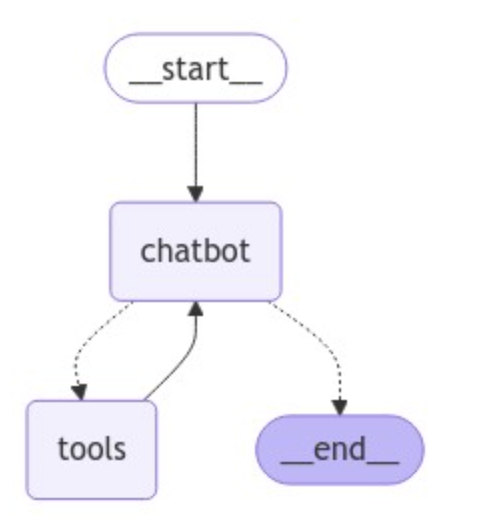

Draw the graph as a PNG image using Mermaid.

        Args:
            curve_style: The style of the edges. Defaults to CurveStyle.LINEAR.
            node_colors: The colors of the nodes. Defaults to NodeStyles().
            wrap_label_n_words: The number of words to wrap the node labels at.
                Defaults to 9.
            output_file_path: The path to save the image to. If None, the image
                is not saved. Defaults to None.
            draw_method: The method to use to draw the graph.
                Defaults to MermaidDrawMethod.API.
            background_color: The color of the background. Defaults to "white".
            padding: The padding around the graph. Defaults to 10.
            frontmatter_config (dict[str, Any], optional): Mermaid frontmatter config.
                Can be used to customize theme and styles. Will be converted to YAML and
                added to the beginning of the mermaid graph. Defaults to None.

                See more here

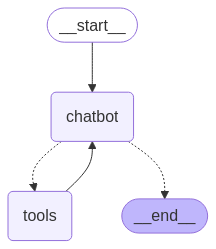

In [56]:
from IPython.display import Image, display

try:
    print(graph.get_graph().draw_mermaid_png.__doc__)
    print(graph.get_graph().draw_mermaid_png.__module__)
    display(Image(graph.get_graph().draw_mermaid_png()))    ###调用API渲染，所以无法输出图片
    

except Exception:
    # This requires some extra dependencies and is optional
    # 这需要一些额外的依赖项并且是可选的
    pass



# from langchain_core.runnables.graph import MermaidDrawMethod

# try:
#     image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.LOCAL)
    
#     # 显示图像
#     display(Image(image_bytes))
    
#     # 保存到文件
#     with open("graph.png", "wb") as f:
#         f.write(image_bytes)
#     print("图片已保存为 graph.png")

# except Exception as e:
#     print(f"本地渲染失败: {e}")


现在我们可以向机器人询问其训练数据之外的问题。

In [57]:
# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            # 检查 value["messages"] 是否是列表
            if isinstance(value.get("messages"), list) and len(value["messages"]) > 0:
                last_message = value["messages"][-1]
                # 检查 last_message 是否是字典
                if isinstance(last_message, dict) and "content" in last_message:
                    print("Assistant:", last_message["content"])
                else:
                    print("Assistant: No content found in message")
            else:
                print("Assistant: No messages in response")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

No tool calls found in response.
State in route_tools: {'messages': [HumanMessage(content='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', additional_kwargs={}, response_metadata={}, id='b09e1026-6d59-49a9-86a9-172d89c585c5'), AIMessage(content="It seems like you've provided a string of characters that doesn't form a clear question or request. Could you please provide more context or specify what you need assistance with? If this is a code or a token of some sort, let me know how you would like to use it, and I'll do my best to help!", additional_kwargs={}, response_metadata={}, id='41412c2a-6614-418c-8d06-7ad3a95a1445')]}
AI message: content="It seems like you've provided a string of characters that doesn't form a clear question or request. Could you please provide more context or specify what you need assistance with? If this is a code or a token of some sort, let me know how you would like to use it, and I'll do my best to help!" additional_kwargs={} response_metadata={} id='41412c2a-66

In [58]:
# from langchain_community.tools.tavily_search import TavilySearchResults

# tool = TavilySearchResults(max_results=1)
# result = tool.invoke("广州今天天气")
# print("Tool result:", result)